# Crunchbase Machine Learning

### About Notebook
This notebook will cover the machine learning portion of The Crunchbase Capstone Project.

If you are interested in seeing the Data Cleaning, Data Wrangling, Exploratory Data Analysis, and Inferential Statistics steps preceeding this notebook please refer to the links below:
- Crunchbase Data Cleaning:
- Crunchbase Data Wrangling: 
- Crunchbase Exploratory Data Analysis: 
- Crunchbase Inferential Statistics: 

### The Question: Will a company be able to raise a next round?

#### Summary
Using a wide variety of data from Crunchbase we hope to build a machine learning model that will help answer the question "Will a company be able to raise a next round?".  We will use the complete dataset that we wrangled in the previous notebooks to train a Random Forest Classifier which will hopefully help us answer this question with some confidence.

# 1. Load Data

In [3]:
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from tqdm import tqdm

#Split Data: Train & Test
from sklearn.model_selection import train_test_split

In [4]:
# Load Final Crunchbase Dataset
final_crunchbase_data = pd.read_csv('data/processed/crunchbase_data.csv').drop(columns=['Unnamed: 0'])

In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
final_crunchbase_data.shape

(1581389, 121)

In [6]:
final_crunchbase_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581389 entries, 0 to 1581388
Columns: 121 entries, company_id to fund_within_year
dtypes: float64(75), int64(37), object(9)
memory usage: 1.4+ GB


# 2. Resample Data

In [7]:
MISC = ['company_permalink','funding_round_permalink','funding_round','funding_round_type',\
        'funding_round_code','prev_funding_round_type','prev_funding_round_code']

# Define Labels
LABEL = ['fund_within_year']

# Define Features
FEATURES = [x for x in final_crunchbase_data.columns if x not in LABEL + MISC]


# Define Text and Numeric Columns
TEXT_COLUMNS = ['short_description','company_category_list']

NUMERIC_COLUMNS = [x for x in final_crunchbase_data[FEATURES].columns if x not in TEXT_COLUMNS + MISC]

In [8]:
# Reduce to df
df = final_crunchbase_data.copy()

# Feature Data
df[FEATURES].head(2)

,company_id,year,quarter,tenure_quarters_overall,tenure_quarters_round,short_description,company_category_list,company_category_count,founding_to_funding_months,founded_yr,...,investor_CAN,investor_ESP,investor_ISR,investor_CHE,investor_JPN,investor_IND,investor_HKG,investor_SGP,investor_CHL,investor_SWE
0,0,2015,1,0,0,Fame is a live video entertainment platform th...,Media,1.0,36.0,2012.0,...,0,0,0,0,0,0,0,0,0,0
1,0,2015,2,1,1,Fame is a live video entertainment platform th...,Media,1.0,36.0,2012.0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df[NUMERIC_COLUMNS].shape

(1581389, 111)

# 3. Create Preprocessing Tools

#### We need to preprocess some of the data before it can be put into the Random Forest model.

The main preprocessing step will involve dealing with text and numeric data as we much process separately and later union them in our pipeline.

#### a. Preprocessing Text Data
To preprocess out text data I used CountVectorizer to vectorize the text columns (short_description, company_category_list, member_titles) so they can be processed in the model.  First we need to combine the columns into one columns which will contain all text (combine_text_columns).  After combining the data it is ready to be vectorized.  Once we vectorize the text data we much later prepare it to combine with numeric data to create the full dataset.   

#### b. FunctionTransformer/FeatureUnion
Because we much first work with the text and numeric data independently we much also combine the data in the pipeline before we can train the model. To do this I used FunctionTransformer on the text and numeric data to format them in the correct way.  Later the reformatted data will be run through FeatureUnion to merge the vectorized text data with the numeric features.

In [9]:
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABEL + MISC):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.
        
        :param data_frame: The data as read in with read_csv (no preprocessing necessary)
        :param to_drop (optional): Removes the numeric and label columns by default.
    """
    # drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # joins all of the text items in a row (axis=1)
    # with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [10]:
from sklearn.preprocessing import FunctionTransformer

get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# 4. Random Forest Classifier Pipeline

With preprocessing tools set up we can now test out the RandomForestClassifier with the dataset we made.  To maximize accuracy as well as minimizing computational cost we have done the following in the pipeline:

#### a. Numeric Preprocessing
First part of the preprocessing is our numeric data.  This will not require too much work as we have done most of the cleaning in the data cleaning and wrangling sets but we still have some missing variables.  For simiplicity we have used an Imputer to fill missing values with the default mean aggregator. This will output a full set of the numeric data.

#### b. Text Preprocessing
Second part of the preprocessing is our text data.  This is a bit more complicated than the numeric data as we much pull text features from all available text in the dataset.  We have three columns that we will be using for this part: ['short_description', 'company_category_list', 'member_titles'].  In order to preprocess this we first combine the three values into a single list which we will pass through a HashingVectorizer to create vector values for our model.  Another option for this would be a CountVectorizer, however, due to the amount of text we have it is better to Hash and then reduce feature.  With the vectorized data we can then reduce the amount of features with SelectKBest which scores all features and returns only the K best features. In this case we chose a K value of 3000. This will output all text data into vectorized hash features.

#### c. Feature Union
With the text and numeric data processed we need to combine them into a single dataset. In the pipeline this is done with FeatureUnion.  Feature Union will combine the two outputs of the text and numeric processing to create a final set that we can then train the RandomForestClassifier with.  One thing that was not stated in the previous steps was FunctionTransformer which both the text and numeric data were passed through which is used to format the data in a way for FeatureUnion to be possible.

#### d. Model
Now that we have preprocessed all of the data we can train and test our models.  The Model we will be using is the Random Forest Classifier.

In [39]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Import other preprocessing modules
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 3000 best features
chi_k = 3000

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

#Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# 5. Random Forest Classifier

For this 

In [25]:
# Features & Labels
X = df[FEATURES]
y = df[LABEL]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=0.3)

# Pipeline
rf_pl = Pipeline([
    ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
])

# Fit
rf_pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x11554bc08>, inv_kw_args=None,
          inverse_func=None, kw_ar...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

# 5. Evaluating the Model

What we want from the Evaluation

1. Accuary Score
2. Cross Validation Score
3. Precision & Recall
4. Confusion Matrix

In [27]:
# Get Predictions and Prediction Probs for Evaluation
predictions = rf_pl.predict(X_test)
prediction_probabilities = rf_pl.predict_proba(X_test)[:,1]

### a) Accuracy

In [26]:
# Score
rf_score = rf_pl.score(X_test, y_test)
rf_score

0.9419540193542811

### b) Cross Validation Score

In [28]:
from sklearn.model_selection import cross_val_score

#Cross Validation Score
cv_results = cross_val_score(rf_pl, X_test, y_test, cv=5)
print("Average CV Score: " + str(cv_results.mean()))

Average CV Score: 0.8909061034040124


### c) Precision & Recall

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print('Classification Report:')
print(classification_report(y_test, predictions))
    
#Confusion Matrix
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    380907
         1.0       0.91      0.78      0.84     93510

   micro avg       0.94      0.94      0.94    474417
   macro avg       0.93      0.88      0.90    474417
weighted avg       0.94      0.94      0.94    474417

Confusion Matrix: 

[[373910   6997]
 [ 20541  72969]]


### d) ROC Curve and AUC Score

AUC Score: 0.9753051327567435


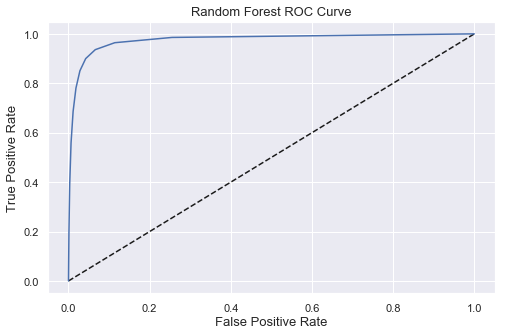

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, prediction_probabilities)

#Plot
_ = plt.figure(figsize=(8,5))
_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Random Forest Classifier')
_ = plt.xlabel('False Positive Rate', size=13)
_ = plt.ylabel('True Positive Rate', size=13)
_ = plt.title('Random Forest ROC Curve', size=13)
_ = plt.savefig('results/random_forest_roc_curve.png')

#ROC AUC Score
print("AUC Score: " + str(roc_auc_score(y_test, prediction_probabilities)))

# 6. Analyzing Results

## a) Overall Error

In [68]:
X_all = df[FEATURES]
y_all = df[LABEL]

In [70]:
# Get Results from Random Forest Classifier
random_forest_df = df.copy()
random_forest_predictions = rf_pl.predict(X)

# Add Predictions to DataFrame
random_forest_df['predictions'] = pd.Series(random_forest_predictions)

In [151]:
# Identify Columns indicating Round Type
round_cols = ['angel','convertible_note', 'debt_financing', 'equity_crowdfunding',\
              'grant', 'non_equity_assistance','private_equity', 'product_crowdfunding',\
              'secondary_market', 'seed','undisclosed', 'venture', 'A', 'B','C', 'D', 'E',\
              'F', 'G', 'H', 'Unknown']

# Calculate Error
error_by_round_rf = pd.DataFrame(random_forest_df[random_forest_df.fund_within_year != random_forest_df.predictions][round_cols].sum() / random_forest_df[round_cols].sum()).reset_index()
error_by_round_rf.columns = ['round','error']

error_by_round_rf['round'] = error_by_round_rf['round'].str.replace('_',' ').str.capitalize()

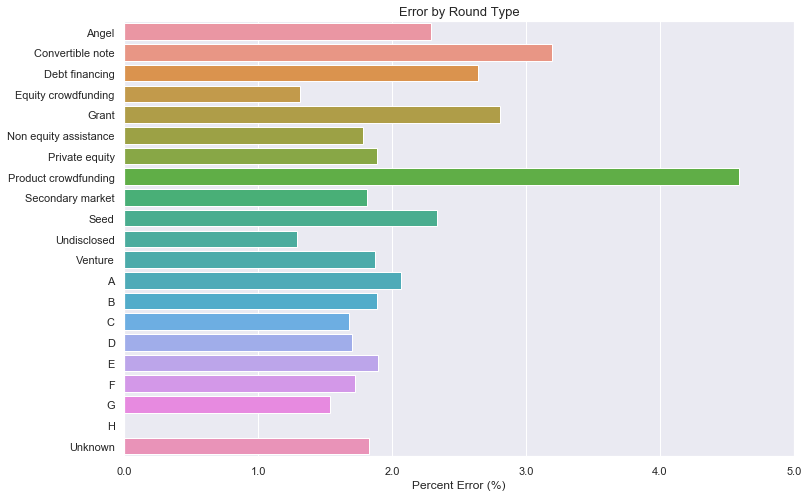

In [159]:
# Plot Error by Round Type
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x='error', y='round', data=error_by_round_rf)
_ = plt.title('Error by Round Type', size=13)
xlocs, xlabels = plt.xticks()
ylocs, ylabels = plt.yticks()
_ = plt.xticks(xlocs, xlocs*100)
_ = plt.xlabel('Percent Error (%)')
_ = plt.ylabel('')
_ = plt.savefig('results/error_by_round_type_sorted.png')

## b) Precision by Round Type
- ### 91% of Predicted Funded Were Actually Funded

In [123]:
# True Positive / (Predicted Positives)
true_positive = random_forest_df[(random_forest_df['fund_within_year'] == 1) & (random_forest_df['predictions'] == 1)]
predicted_positives = random_forest_df[random_forest_df['predictions'] == 1]

# Get True Positives By Round
true_positive_by_round = pd.DataFrame(true_positive[round_cols].sum()).reset_index()
true_positive_by_round.columns = ['round','true_positives']

# Get Predicted Positives By Round
predicted_positives_by_round = pd.DataFrame(predicted_positives[round_cols].sum()).reset_index()
predicted_positives_by_round.columns = ['round','predicted_positives']

# Merge True Positives and Predicted Positives
precision_by_round = true_positive_by_round.merge(predicted_positives_by_round)

In [149]:
# Calculate Precision
precision_by_round['precision'] = precision_by_round['true_positives'] / precision_by_round['predicted_positives']
precision_by_round['round'] = precision_by_round['round'].str.replace('_',' ').str.capitalize()

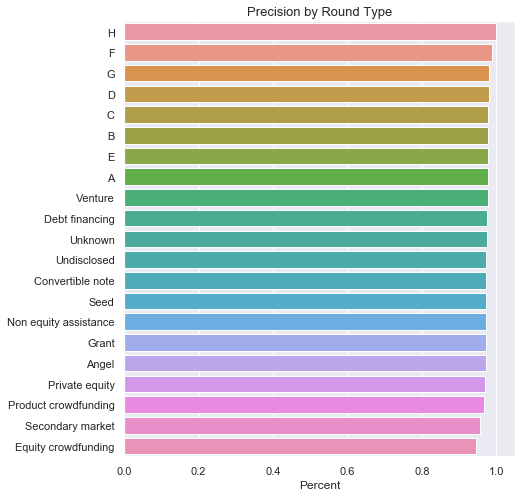

In [169]:
# Plot Error by Round Type
_ = plt.figure(figsize=(7,8))
_ = sns.barplot(x='precision', y='round', data=precision_by_round.sort_values('precision', ascending=False))
_ = plt.title('Precision by Round Type', size=13)
_ = plt.xlabel('Percent')
_ = plt.ylabel('')
_ = plt.savefig('results/precision_by_round_type.png')

## c) Recall by Round Type
- ### 78% of Actual Funded Rounds Were Identified as Funded

In [99]:
# True Positive / (Actual Positives)
actual_positives = random_forest_df[random_forest_df['fund_within_year'] == 1]

In [129]:
# Get Predicted Positives By Round
actual_positives_by_round = pd.DataFrame(actual_positives[round_cols].sum()).reset_index()
actual_positives_by_round.columns = ['round','actual_positives']

# Merge True Positives and Predicted Positives
recall_by_round = true_positive_by_round.merge(actual_positives_by_round)

In [154]:
# Calculate Recall by Round Type
recall_by_round['recall'] = recall_by_round['true_positives'] / recall_by_round['actual_positives']
recall_by_round['round'] = recall_by_round['round'].str.replace('_',' ').str.capitalize()

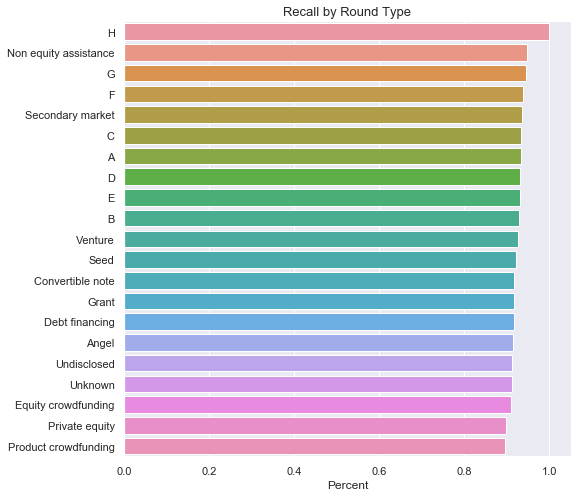

In [170]:
# Plot Error by Round Type
_ = plt.figure(figsize=(8,8))
_ = sns.barplot(x='recall', y='round', data=recall_by_round.sort_values('recall', ascending=False))
_ = plt.title('Recall by Round Type', size=13)
_ = plt.xlabel('Percent')
_ = plt.ylabel('')
_ = plt.savefig('results/recall_by_round_type.png')

# Conclusion

In [38]:
%load_ext watermark
%watermark -a "Daiki Minaki" -d -t -v -p numpy,pandas -g

Daiki Minaki 2019-02-21 14:22:16 

CPython 2.7.3
IPython 5.8.0

numpy 1.14.2
pandas 0.24.1
Git hash: 3a9cdd1006e2482b9dfbde515774c4a402d75ac1
